In [1]:
# buat visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# manipulasi data
import numpy as np
import pandas as pd

# preprosessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# buat pipe line
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model
from sklearn.ensemble import GradientBoostingRegressor

# evaluasi
from sklearn.metrics import make_scorer, mean_squared_error

c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#variabel konstan
CV_FOLDS = 3
N_ITER = 10
VERBOSITY = 5
RANDOM_STATE = 2049

In [3]:
#load datasets
data_path = '../data/'

# Load dataset

In [4]:
# Loading training dataset
train_data = pd.read_csv(data_path + "train.csv")

# Loading test dataset
test_data = pd.read_csv(data_path + "test.csv")

## Cek Missing

In [5]:
def identify_missing_values(data):
    """Menghitung missing values"""
    # validasi kolom yang ada missing
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]

    # buat table untuk nampung perhitungan nilai missing
    cols = {"missing_count": miss_vals_num.values}
    nans_df = pd.DataFrame(data=cols, index=miss_vals_num.index).sort_values(
        by="missing_count", ascending=False
    )
    
    # masukan nilai perhitungan kedalam table yang sebelumnya dibuat 
    nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
    nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)
    nans_df["dtype"] = data[nans_df.index].dtypes
    nans_df = nans_df[["dtype", "missing_count", "missing_fraction"]]

    return nans_df

In [6]:
# Computing missing values
miss_vals = identify_missing_values(data=train_data)

In [7]:
miss_vals

,dtype,missing_count,missing_fraction
PoolQC,object,1453,0.9952
MiscFeature,object,1406,0.9630
Alley,object,1369,0.9377
Fence,object,1179,0.8075
FireplaceQu,object,690,0.4726
LotFrontage,float64,259,0.1774
GarageType,object,81,0.0555
GarageYrBlt,float64,81,0.0555
GarageFinish,object,81,0.0555
GarageQual,object,81,0.0555


In [8]:
# nampilin data missing yang numeric
miss_vals[miss_vals['dtype'] != "object"]

,dtype,missing_count,missing_fraction
LotFrontage,float64,259,0.1774
GarageYrBlt,float64,81,0.0555
MasVnrArea,float64,8,0.0055


In [9]:
# mengisi missing value
train_data[['MasVnrArea','LotFrontage']] = train_data[['MasVnrArea','LotFrontage']].fillna(train_data[['MasVnrArea','LotFrontage']].median())
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean())

In [10]:
# cek lagi
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals['dtype'] != "object"]

,dtype,missing_count,missing_fraction


In [11]:
# nampilin data missing yang object
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals["dtype"] == "object"]

,dtype,missing_count,missing_fraction
PoolQC,object,1453,0.9952
MiscFeature,object,1406,0.9630
Alley,object,1369,0.9377
Fence,object,1179,0.8075
FireplaceQu,object,690,0.4726
GarageType,object,81,0.0555
GarageFinish,object,81,0.0555
GarageQual,object,81,0.0555
GarageCond,object,81,0.0555
BsmtExposure,object,38,0.0260


In [12]:
# apus kolom dengan missing values lebih dari 70%
train_data = train_data.drop(miss_vals[miss_vals.missing_fraction > 0.7].index.tolist(),1)

C:\Users\RanggaSaputra\AppData\Local\Temp\ipykernel_23628\2773110458.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_data = train_data.drop(miss_vals[miss_vals.missing_fraction > 0.7].index.tolist(),1)


In [13]:
# cek lagi
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals["dtype"] == "object"]

,dtype,missing_count,missing_fraction
FireplaceQu,object,690,0.4726
GarageType,object,81,0.0555
GarageFinish,object,81,0.0555
GarageQual,object,81,0.0555
GarageCond,object,81,0.0555
BsmtExposure,object,38,0.0260
BsmtFinType2,object,38,0.0260
BsmtQual,object,37,0.0253
BsmtCond,object,37,0.0253
BsmtFinType1,object,37,0.0253


In [14]:
# Dropping NaN-values in columns with small shares
cols_to_fillna = miss_vals.index
train_data.fillna(train_data.mode().iloc[0], inplace=True)

In [15]:
# cek lagi
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals["dtype"] == "object"]

,dtype,missing_count,missing_fraction


In [16]:
train_data_num = train_data.select_dtypes(include=['int64', 'float64'])
train_data_num.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500


## cari korelasi yang lebih dari 0.4

In [17]:
train_data_num_corr =train_data_num.corr()['SalePrice'][:-1]
best_featur = train_data_num_corr[abs(train_data_num_corr)>0.4].sort_values(ascending=False)

In [18]:
print(f"There Are {len(best_featur)} Best Features with SalePrice \n\n{best_featur}")

There Are 13 Best Features with SalePrice 

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
GarageYrBlt     0.470177
Fireplaces      0.466929
Name: SalePrice, dtype: float64


In [19]:
best_featur.index

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'GarageYrBlt', 'Fireplaces'],
      dtype='object')

In [20]:
best_num_featurelist = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'MasVnrArea', 'Fireplaces','SalePrice']

train_data_num_featur = train_data.loc[:, best_num_featurelist].copy()

In [21]:
train_data_num_featur.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,SalePrice
0,7,1710,2,548,856,856,2,8,2003,2003,2003.0,196.0,0,208500
1,6,1262,2,460,1262,1262,2,6,1976,1976,1976.0,0.0,1,181500
2,7,1786,2,608,920,920,2,6,2001,2002,2001.0,162.0,1,223500
3,7,1717,3,642,756,961,1,7,1915,1970,1998.0,0.0,1,140000
4,8,2198,3,836,1145,1145,2,9,2000,2000,2000.0,350.0,1,250000


## Buat cek korelasi ke sales price

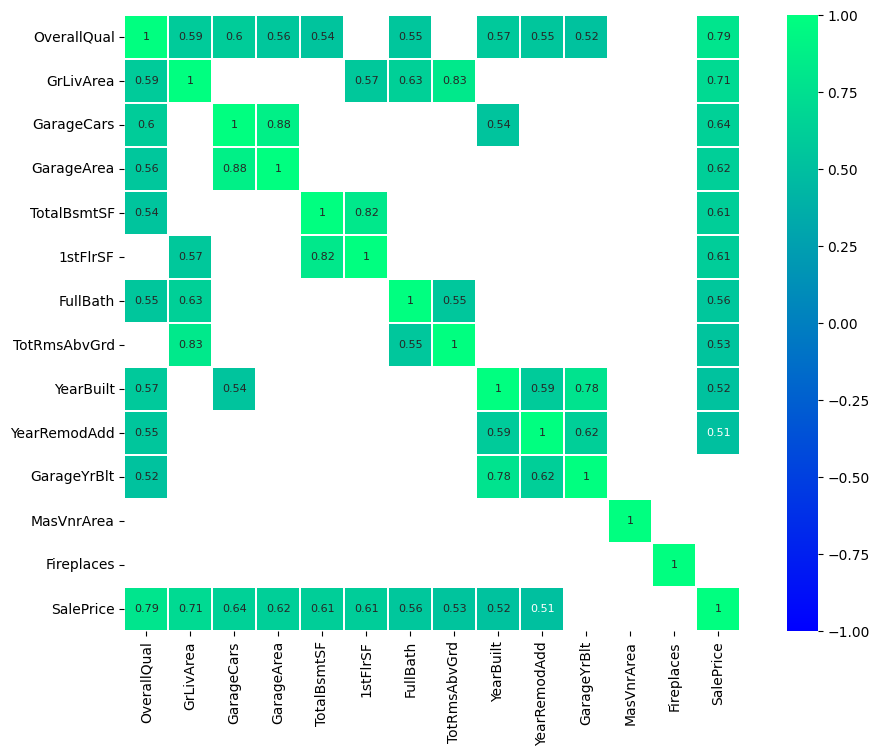

In [22]:
corr = train_data_num_featur.corr()
paper=plt.figure(figsize=(12,8))
sns.heatmap(corr[(corr>=0.5) |(corr<= -0.4)] ,
            cmap='winter', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

plt.show()

diapus karena tidak ada korelasi sama salesprice

In [23]:
train_data_num_featur = train_data_num_featur.drop(['GarageYrBlt', 'MasVnrArea', 'Fireplaces'], axis=1)

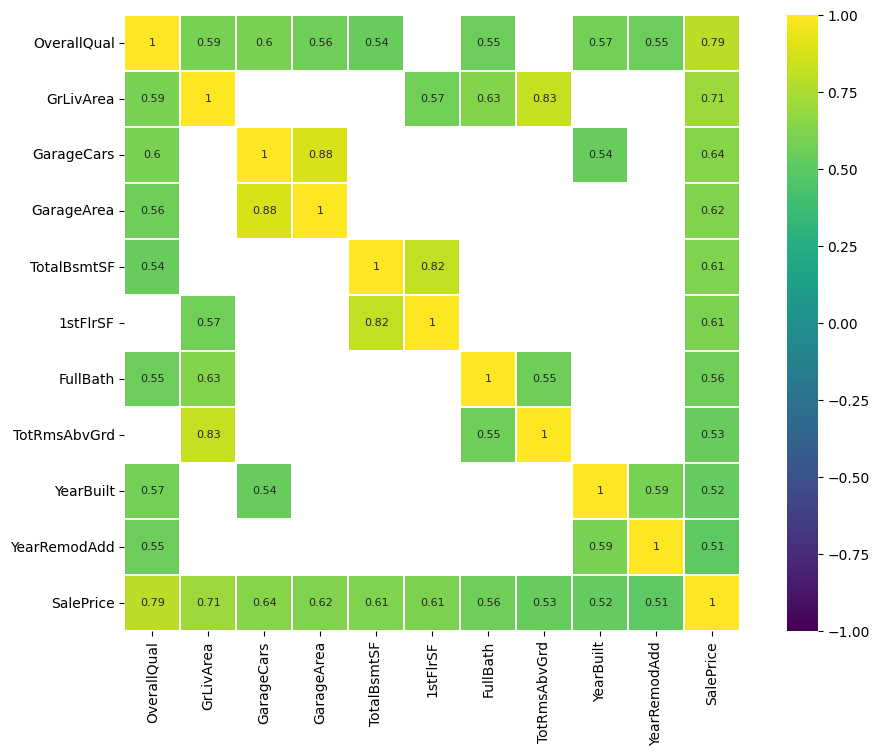

In [24]:
corr = train_data_num_featur.corr()
paper=plt.figure(figsize=(12,8))
sns.heatmap(corr[(corr>=0.5) |(corr<= -0.4)] ,
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

plt.show()

## olah data kategori

In [25]:
train_data_cat = train_data.select_dtypes(include=['object'])
train_data_cat.head(2)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [26]:
train_data_cat.nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

Drop yang kebanyak dimensi

In [27]:
train_data_cat.drop(columns=['Neighborhood'], inplace = True)

In [28]:
threshold = 0.70  # tetapkan ambang batas

'''
hitung frekuensi banyaknya suatu kategori
ini digunakan agar data tidak menjadi homogen
'''
category_counts = train_data_cat.apply(lambda col: col.value_counts().max() / len(col))

# pisahkan dari setiap fitur data
unrelevant_columns = category_counts[category_counts > threshold].index
relevant_columns = category_counts[category_counts < threshold].index

In [29]:
# banyaknya data yang baik digunakan
print(train_data_cat[relevant_columns].shape)
print(f'Numerical {train_data_num_featur.shape}')

(1460, 14)
Numerical (1460, 11)


In [30]:
relevant_columns = train_data[relevant_columns]

## Seleksi Fitur

In [31]:
# buat data train berdasarkan fitur yang sudah di filter
train_data_best = pd.concat([relevant_columns, train_data_num_featur], axis=1)
train_data_best

,LotShape,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,...,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
0,Reg,2Story,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,...,1710,2,548,856,856,2,8,2003,2003,208500
1,Reg,1Story,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,...,1262,2,460,1262,1262,2,6,1976,1976,181500
2,IR1,2Story,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,...,1786,2,608,920,920,2,6,2001,2002,223500
3,IR1,2Story,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,...,1717,3,642,756,961,1,7,1915,1970,140000
4,IR1,2Story,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,...,2198,3,836,1145,1145,2,9,2000,2000,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Reg,2Story,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,...,1647,2,460,953,953,2,7,1999,2000,175000
1456,Reg,1Story,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,...,2073,2,500,1542,2073,2,7,1978,1988,210000
1457,Reg,2Story,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,...,2340,1,252,1152,1188,2,9,1941,2006,266500
1458,Reg,1Story,MetalSd,MetalSd,None,TA,CBlock,TA,Mn,GLQ,...,1078,1,240,1078,1078,1,5,1950,1996,142125


In [32]:
train_data_best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LotShape      1460 non-null   object
 1   HouseStyle    1460 non-null   object
 2   Exterior1st   1460 non-null   object
 3   Exterior2nd   1460 non-null   object
 4   MasVnrType    1460 non-null   object
 5   ExterQual     1460 non-null   object
 6   Foundation    1460 non-null   object
 7   BsmtQual      1460 non-null   object
 8   BsmtExposure  1460 non-null   object
 9   BsmtFinType1  1460 non-null   object
 10  HeatingQC     1460 non-null   object
 11  KitchenQual   1460 non-null   object
 12  GarageType    1460 non-null   object
 13  GarageFinish  1460 non-null   object
 14  OverallQual   1460 non-null   int64 
 15  GrLivArea     1460 non-null   int64 
 16  GarageCars    1460 non-null   int64 
 17  GarageArea    1460 non-null   int64 
 18  TotalBsmtSF   1460 non-null   int64 
 19  1stFlr

## Cek persebaran data test

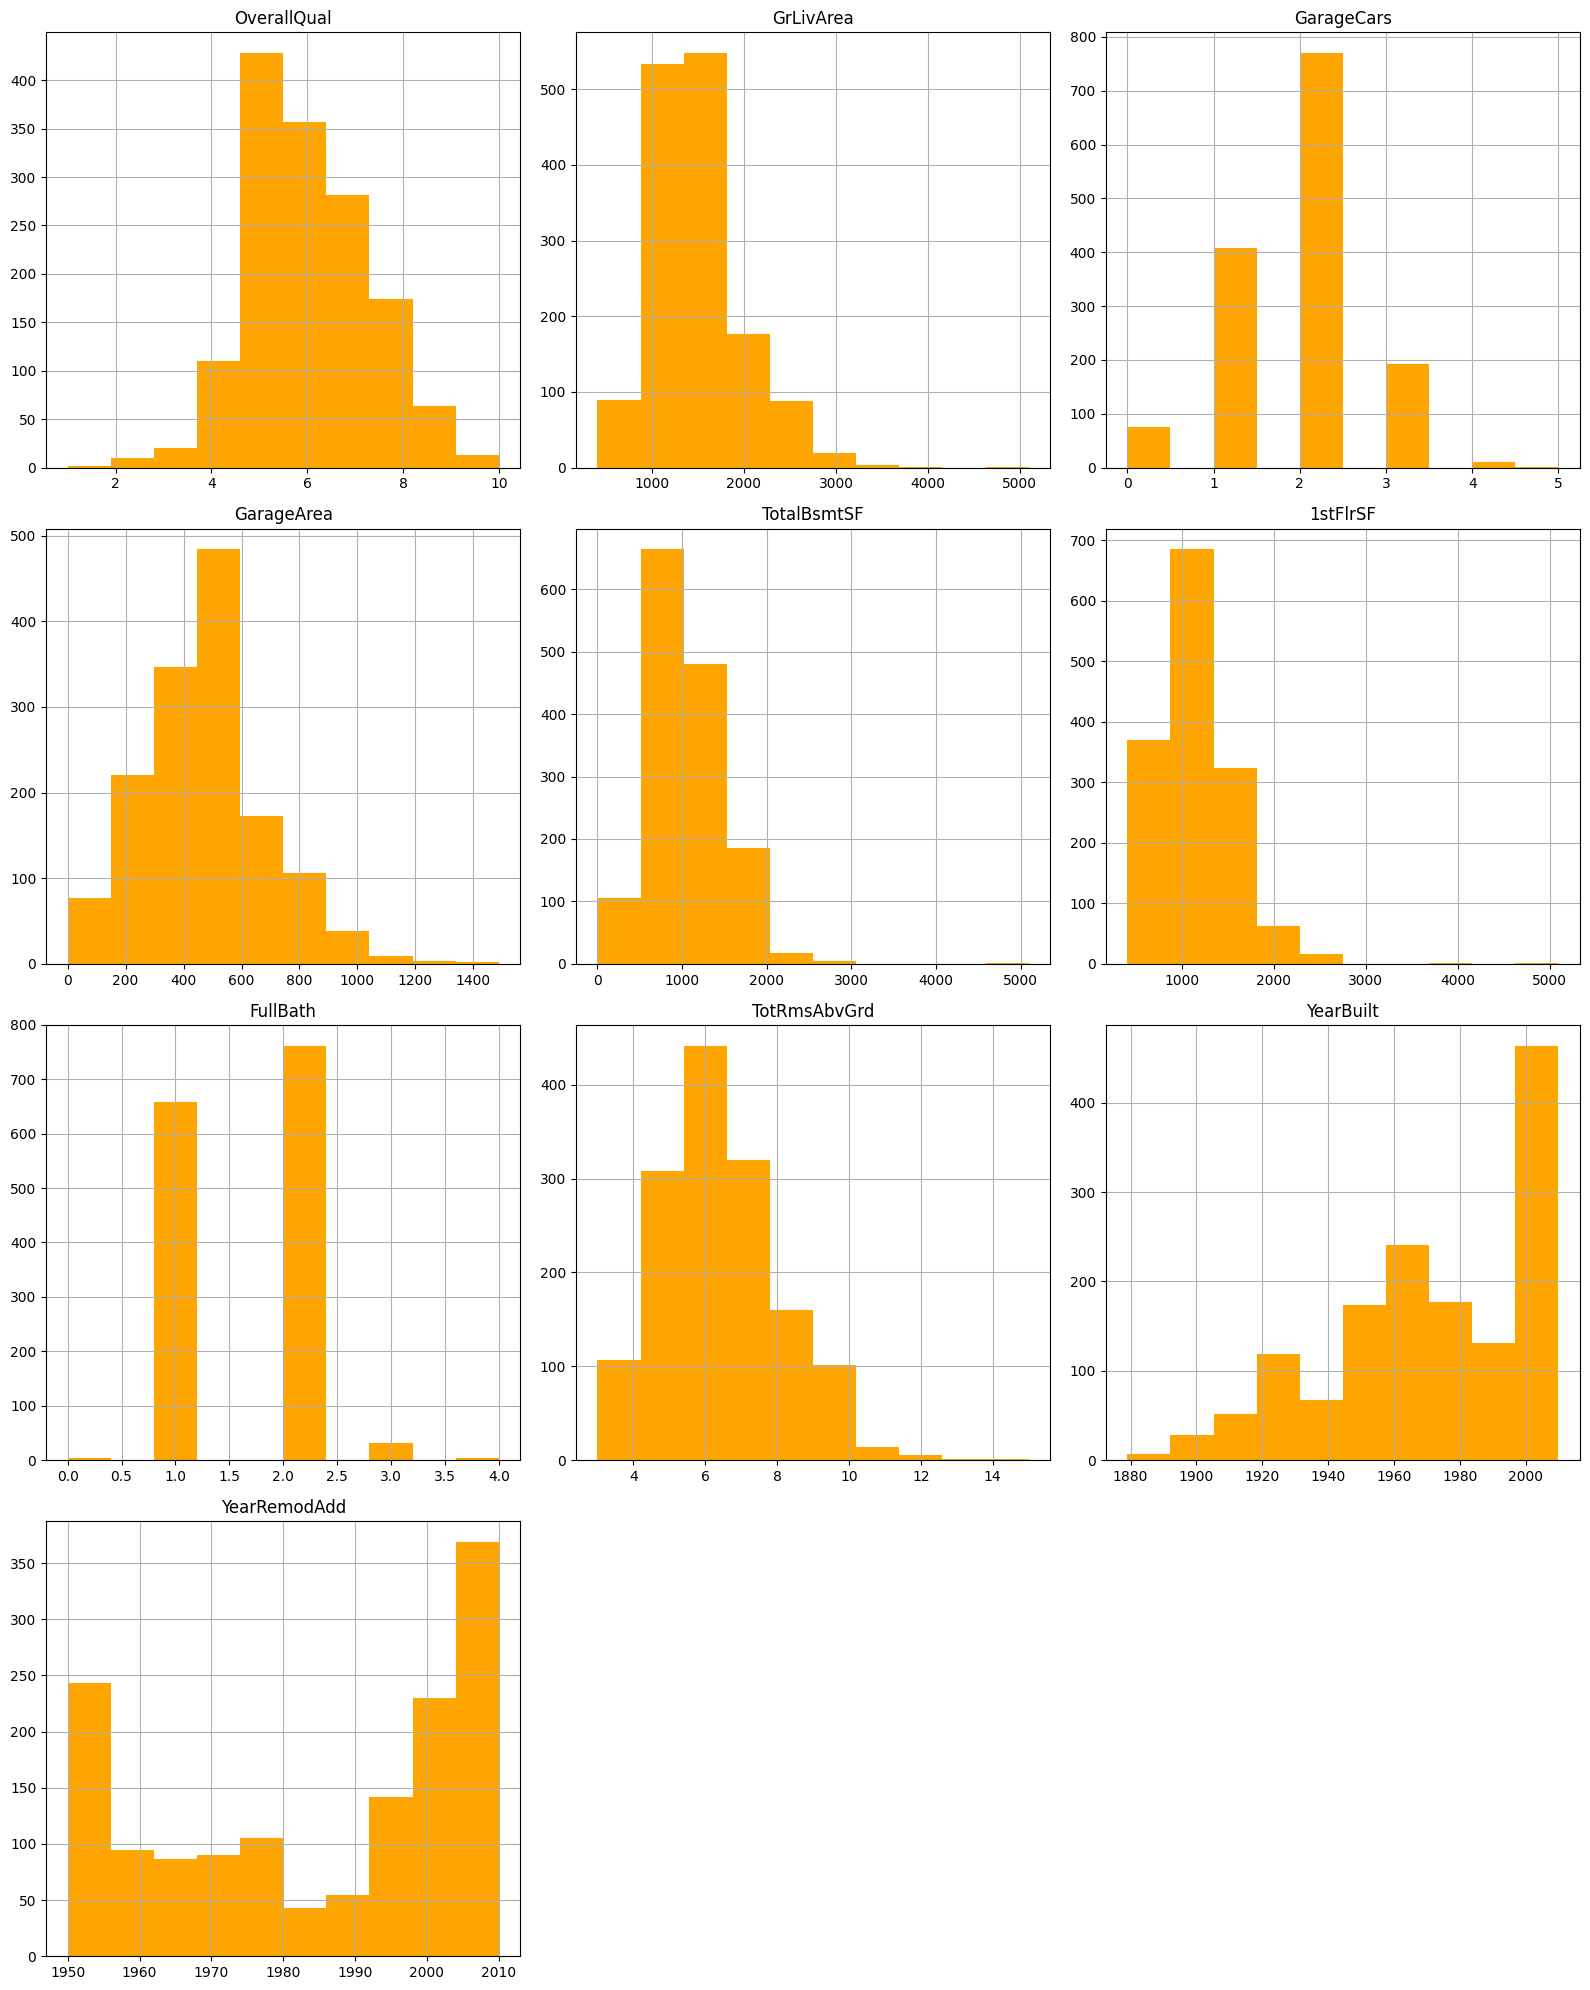

In [33]:
train_data_cols = train_data_best.drop(["SalePrice"], axis=1).columns
test_data[train_data_cols].hist(figsize=(16, 20), color="orange")
plt.tight_layout()
plt.show()

## Cek missing values di test data

In [34]:
# cek missing value
identify_missing_values(data=test_data[train_data_cols])

,dtype,missing_count,missing_fraction
GarageFinish,object,78,0.0535
GarageType,object,76,0.0521
BsmtQual,object,44,0.0302
BsmtExposure,object,44,0.0302
BsmtFinType1,object,42,0.0288
MasVnrType,object,16,0.0110
Exterior1st,object,1,0.0007
Exterior2nd,object,1,0.0007
KitchenQual,object,1,0.0007
GarageCars,float64,1,0.0007


## Buat pipeline

In [35]:
# Pisahkan fitur kategori, fitur ordinal, fitur numerik
fitur_numerik = ['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']
fitur_ordinal = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual']
fitur_kategori = ['LotShape',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'GarageType',
 'GarageFinish']

In [56]:
# Daftar urutan kategori
order_qual_BsmtQual = ['Ex', 'Gd', 'Ta', 'Fa']
order_qual_BsmtExposure = ['Gd', 'Av', 'Mn', 'No']
order_qual_BsmtFinType1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf']
order_qual_HeatingQC = ['Ex', 'Gd', 'Ta', 'Fa', 'Po']
order_qual_KitchenQual = ['Ex', 'Gd', 'Ta', 'Fa']

# untuk tranformasi dan preprosessing data
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[order_qual_BsmtQual, order_qual_BsmtExposure, 
                                               order_qual_BsmtFinType1, order_qual_HeatingQC, 
                                               order_qual_KitchenQual], 
                                               handle_unknown='use_encoded_value',
                                               unknown_value=np.nan), 
                                               fitur_ordinal),
        ('onehot', OneHotEncoder(drop="first",
                                 handle_unknown='ignore'), 
                                 fitur_kategori),
        ('scaler', StandardScaler(), fitur_numerik)  # Standarisasi data numerik
    ])

# Buat langkah dalam pipeline
steps = [
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mengisi missing values dengan nilai yang paling sering muncul
]

## Buat evalusi

In [57]:
def rmse_log_scorer(y_true, y_pred):
    """Computes RMSE between log predictions and log true values."""
    # Computing logarithms of true and predicted values
    log_y_true = np.log(y_true)
    log_y_pred = np.log(y_pred)
    
    # Computing RMSE for logs
    rmse_score = mean_squared_error(
        y_true=log_y_true, y_pred=log_y_pred, squared=False
    )
    
    return rmse_score

In [58]:
rmse_scorer = make_scorer(rmse_log_scorer, greater_is_better=False)

In [59]:
target_train = train_data["SalePrice"]

features_train = train_data.drop(["SalePrice"], axis=1)

features_test = test_data[features_train.columns]

## bagi data test dan train

In [68]:
from sklearn.model_selection import train_test_split

# Bagi data Anda menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=42)

## Untuk memilih algoritma terbaik

lazypredict itu gabungan dari banyak algoritma jadi kita ngg usah test satu satu

In [71]:
from lazypredict.Supervised import LazyRegressor

# melihat referensi model yang bisa digunakan
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models_reg, predictions_reg = reg.fit(X_train, X_test, y_train, y_test)
models_reg.sort_values(by='R-Squared', ascending=False)

100%|██████████| 42/42 [01:49<00:00,  2.61s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.86,0.90,27808.69,1.46
PoissonRegressor,0.86,0.90,28200.36,0.25
RandomForestRegressor,0.86,0.89,28640.35,2.83
HistGradientBoostingRegressor,0.85,0.89,29095.50,6.92
LGBMRegressor,0.85,0.89,29134.84,0.17
LassoLars,0.85,0.89,29171.08,0.27
Lasso,0.85,0.89,29206.24,0.51
LassoLarsIC,0.85,0.89,29259.73,0.49
HuberRegressor,0.84,0.88,30076.35,0.79


GradientBoostingRegressor memiliki nilai R-Squared yang tinggi, RMSE yang rendah, dan waktu pelatihan yang wajar (1.46 detik). Oleh karena itu, model ini bisa menjadi pilihan yang baik.

## satukan algoritma dengan pipe line

In [60]:
gbr_model = GradientBoostingRegressor(random_state=RANDOM_STATE)
steps.append(('Gbr', gbr_model))

gbr_pipeline = Pipeline(steps)

gbr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Ex',
                                                                              'Gd',
                                                                              'Ta',
                                                                              'Fa'],
                                                                             ['Gd',
                                                                              'Av',
                                                                              'Mn',
                                                                              'No'],
                                                                             ['GLQ',
                                                                              'ALQ',
                                                                              'BLQ',
                                                                              'Rec',
                                                                              'LwQ',
                                                                              'Unf'],
                                                                             ['Ex',
                                                                              'Gd',
                                                                              'Ta',
                                                                              'Fa',
                                                                              'Po'],
                                                                             ['Ex',
                                                                              'Gd',
                                                                              'Ta',
                                                                              'Fa']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['BsmtQual', 'BsmtExposure',
                                                   'BsmtFinType1', 'HeatingQC',
                                                   'Kitchen...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'Foundation', 'GarageType',
                                                   'GarageFinish']),
                                                 ('scaler', StandardScaler(),
                                                  ['OverallQual', 'GrLivArea',
                                                   'GarageCars', 'GarageArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'FullBath', 'TotRmsAbvGrd',
                                                   'YearBuilt',
                                                   'YearRemodAdd'])])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('Gbr', GradientBoostingRegressor(random_state=2049))])

## tuning parameter

In [64]:
param_dist = {
    'Gbr__n_estimators': np.arange(50, 300, 10),
    'Gbr__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'Gbr__max_depth': [3, 4, 5, 6],
}

In [65]:
# Instantiating a RSCV object
gbr_grid_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_dist,
    scoring=rmse_scorer,
    cv=CV_FOLDS,
    n_iter=N_ITER,
    random_state=RANDOM_STATE,
    verbose=VERBOSITY,
    return_train_score=True,
)

## lakukan eksekusi model

In [66]:
# Launching randomized grid search algorithm 
gbr_grid_search.fit(features_train, target_train)

# Menampilkan hasil terbaik dari pencarian acak
print("Best Parameters: ", gbr_grid_search.best_params_)
print("Best Score (RMSE): ", -gbr_grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=5, Gbr__n_estimators=170;, score=(train=-0.017, test=-0.157) total time=   0.8s
[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=5, Gbr__n_estimators=170;, score=(train=-0.018, test=-0.163) total time=   0.7s
[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=5, Gbr__n_estimators=170;, score=(train=-0.017, test=-0.152) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=5, Gbr__n_estimators=70;, score=(train=-0.069, test=-0.151) total time=   0.2s
[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=5, Gbr__n_estimators=70;, score=(train=-0.066, test=-0.157) total time=   0.2s
[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=5, Gbr__n_estimators=70;, score=(train=-0.072, test=-0.148) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=5, Gbr__n_estimators=200;, score=(train=-0.035, test=-0.153) total time=   0.8s
[CV 2/3] END Gbr__